# Импорт библиотек 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    roc_auc_score, recall_score, confusion_matrix, roc_curve,
    precision_recall_curve, classification_report
)


In [2]:
def simple_clearing_train(df_train: pd.DataFrame, fill_percent_threshold=97, corr_percent_threshold=100, onlyfloat=False):
    df = df_train
    
    # Дроп столбцов, заполненных меньше, чем не fiil_percent_threshold %
    df = df.drop(columns=[col for col in df.columns
        if df[col].count() / len(df.index) < fill_percent_threshold / 100])
    
    
    # Замена None в категориальных данных на новый категориальный признак
    categorical_columns = [col for col in df.columns if str(df[col].dtype) == 'object']
    df[categorical_columns] = df[categorical_columns].fillna('CatNone')
    
    # Замена NaN в числовых данных на медианное значение
    float_columns = [col for col in df.columns if str(df[col].dtype) == 'float64']
    df[float_columns] = df[float_columns].fillna(df[float_columns].median())
    
    # Разбиение категории segment на пять бинарных столбцов
    dummies = pd.get_dummies(df,
        columns=['segment'])[[f'segment_{n}' for n in [0, 1, 2, 3, 'CatNone']]].astype(np.float64)
    segment_idx = df.columns.get_loc('segment')
    df = df.drop(columns=['segment'])
    for n in ['CatNone', 3, 2, 1, 0]:
        df.insert(segment_idx, f'segment_{n}', dummies[f'segment_{n}'])
        
    # Если интересуют только числовые данные
    if onlyfloat:
        float_columns = [col for col in df.columns if str(df[col].dtype) in ('float64', 'int32')]
        df = df[float_columns]
        
    # Дроп столбцов, кореллирующих с какими-либо другими более, чем на corr_percent_threshold %
    """
    if corr_percent_threshold < 100:
        float_columns = [col for col in df.columns if str(df[col].dtype) == 'float64']
        dff = df[float_columns]
        dff_corr = dff.corr()
        most_corellated_pairs = [
            (dff.columns[i], dff.columns[j], dff_corr[dff.columns[i]].loc[dff.columns[j]])
            for i in range(len(dff.columns))
            for j in range(i+1, len(dff.columns))
        ]
        most_corellated_pairs.sort(
            key=lambda col_pair: abs(col_pair[2]), reverse=True
        )
        most_corellated_pairs = pd.DataFrame(data=most_corellated_pairs,
            columns=['feature_1', 'feature_2', 'correllation'])
        mcp = most_corellated_pairs
        while mcp['correllation'].iloc[0] > (corr_percent_threshold / 100):
            c11 = (mcp['feature_1'].value_counts().loc[mcp['feature_1'].iloc[0]]
                if mcp['feature_1'].iloc[0] in mcp['feature_1'].value_counts().index else 0)
            c21 = (mcp['feature_2'].value_counts().loc[mcp['feature_1'].iloc[0]]
                if mcp['feature_1'].iloc[0] in mcp['feature_2'].value_counts().index else 0)
            c12 = (mcp['feature_1'].value_counts().loc[mcp['feature_2'].iloc[0]]
                if mcp['feature_2'].iloc[0] in mcp['feature_1'].value_counts().index else 0)
            c22 = (mcp['feature_2'].value_counts().loc[mcp['feature_2'].iloc[0]]
                if mcp['feature_2'].iloc[0] in mcp['feature_2'].value_counts().index else 0)
            excessive_feature = mcp['feature_1'].iloc[0] if c11 + c21 < c12 + c22 else mcp['feature_2'].iloc[0]
            df = df.drop(columns=[excessive_feature])
            dff = dff.drop(columns=[excessive_feature])
            dff_corr = dff_corr.drop(columns=[excessive_feature])
            dff_corr = dff_corr.drop(index=[excessive_feature])
            mcp = mcp.loc[(mcp['feature_1'] != excessive_feature) & (mcp['feature_2'] != excessive_feature)]
    """
    return df

def simple_clearing_test(df_test: pd.DataFrame, df_train_clean: pd.DataFrame):
    # Выбор только тех столбцов, которые были в трейне
    targets = ['target_1', 'target_2', 'total_target']

    # Разбиение категории segment на пять бинарных столбцов
    dummies = pd.get_dummies(df_test, columns=['segment'])
    if 'segment_CatNone' not in dummies.columns:
        dummies.insert(len(dummies.columns), 'segment_CatNone', 0.0)
    dummies = dummies[[f'segment_{n}' for n in [0, 1, 2, 3, 'CatNone']]].astype(np.float64)
    segment_idx = df_test.columns.get_loc('segment')
    df_test = df_test.drop(columns=['segment'])
    for n in ['CatNone', 3, 2, 1, 0]:
        df_test.insert(segment_idx, f'segment_{n}', dummies[f'segment_{n}'])
    
    df_train_clean_columns = [col for col in df_train_clean.columns if col not in targets]
    df_test = df_test[df_train_clean_columns]
    
    """
    # Замена None в категориальных данных на новый категориальный признак
    categorical_columns = [col for col in df_test.columns if str(df_test[col].dtype) == 'object']
    df_test[categorical_columns] = df_test[categorical_columns].fillna('CatNone')
    # Замена NaN в числовых данных на медианное значение
    float_columns = [col for col in df_test.columns if str(df_test[col].dtype) == 'float64']
    df_test[float_columns] = df_test[float_columns].fillna(df_test[float_columns].median())
    """
    return df_test

In [3]:
file_path = '../test.parquet'
test_data = pd.read_parquet(file_path, engine='pyarrow')

file_path = '../train.parquet'
train_data = pd.read_parquet(file_path, engine='pyarrow')

train_data = simple_clearing_train(train_data, 80, 100, False)

categorical_columns = [col for col in train_data.columns if str(train_data[col].dtype) == 'object']

train_data = train_data.drop(columns=categorical_columns)

train_data.isnull().any().sum()

0

In [4]:
test_data = simple_clearing_test(test_data, train_data)

In [5]:
def clear_outliers_column(df1, column, a_max, b_min):
    a_max = df1[column].max() * a_max
    b_min = df1[column].min() * b_min
    df1 = df1.drop(df1[df1[column] < b_min].index)
    df1 = df1.drop(df1[df1[column] > a_max].index)
    return df1


def clear_outliers_all(df1):
    try:
    # rko_start_months
        df1 = clear_outliers_column(df1, 'rko_start_months', 0.6, 0.9)
        print(df1.size)
    except:
        print('rko_start_months')

    try:
        # balance_amt_avg
        df1 = clear_outliers_column(df1, 'balance_amt_avg', 0.2, 1)
    except:
        print('balance_amt_avg')

    try:
        # balance_amt_max
        df1 = clear_outliers_column(df1, 'balance_amt_max', 0.05, 1)
    except:
        print('balance_amt_max')

    try:
        # balance_amt_min
        df1 = clear_outliers_column(df1, 'balance_amt_min', 0.25, 1)
    except:
        print('balance_amt_min')

    try:
        # balance_amt_day_avg
        df1 = clear_outliers_column(df1, 'balance_amt_day_avg', 0.5, 1)
    except:
        print('balance_amt_day_avg')

    try:
        # ogrn_days_end_month
        df1 = clear_outliers_column(df1, 'ogrn_days_end_month', 0.9, 0.9)
    except:
        print('ogrn_days_end_month')

    try:
        # ogrn_days_end_quarter
        df1 = clear_outliers_column(df1, 'ogrn_days_end_quarter', 0.9, 0.9)
    except:
        print('ogrn_days_end_quarter')

    try:
        # ogrn_exist_months
        df1 = clear_outliers_column(df1, 'ogrn_exist_months', 0.9, 0.9)
    except:
        print('ogrn_exist_months')

    try:
        # sum_of_paym_2m
        df1 = clear_outliers_column(df1, 'sum_of_paym_2m', 0.2, 1)
    except:
        print('sum_of_paym_2m')

    try:
        # sum_of_paym_6m
        df1 = clear_outliers_column(df1, 'sum_of_paym_6m', 0.15, 1)
    except:
        print('sum_of_paym_6m')

    try:
        # sum_of_paym_1y
        df1 = clear_outliers_column(df1, 'sum_of_paym_1y', 0.3, 1)
    except:
        print('sum_of_paym_1y')

    try:
        # sum_a_oper_1m
        df1 = clear_outliers_column(df1, 'sum_a_oper_1m', 0.25, 1)
    except:
        print('sum_a_oper_1m')

    try:
        # cnt_a_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_a_oper_1m', 0.5, 1)
    except:
        print('cnt_a_oper_1m')

    try:
        # sum_b_oper_1m
        df1 = clear_outliers_column(df1, 'sum_b_oper_1m', 0.25, 1)
    except:
        print('sum_b_oper_1m')

    try:
        # cnt_b_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_b_oper_1m', 0.1, 1)
    except:
        print('cnt_b_oper_1m')

    try:
        # sum_c_oper_1m
        df1 = clear_outliers_column(df1, 'sum_c_oper_1m', 0.25, 1)
    except:
        print('sum_c_oper_1m')

    try:
        # cnt_c_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_c_oper_1m', 0.25, 1)
    except:
        print('cnt_c_oper_1m')

    try:
        # sum_deb_d_oper_1m
        df1 = clear_outliers_column(df1, 'sum_deb_d_oper_1m', 0.2, 0.9)
    except:
        print('sum_deb_d_oper_1m')

    try:
        # cnt_deb_d_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_deb_d_oper_1m', 0.2, 0.9)
    except:
        print('cnt_deb_d_oper_1m')

    try:
        # sum_cred_d_oper_1m
        df1 = clear_outliers_column(df1, 'sum_cred_d_oper_1m', 0.2, 0.9)
    except:
        print('sum_cred_d_oper_1m')

    try:
        # cnt_cred_d_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_cred_d_oper_1m', 0.2, 1)
    except:
        print('cnt_cred_d_oper_1m')

    try:
        # sum_deb_e_oper_1m
        df1 = clear_outliers_column(df1, 'sum_deb_e_oper_1m', 0.2, 1)
    except:
        print('sum_deb_e_oper_1m')

    try:
        # cnt_deb_e_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_deb_e_oper_1m', 0.4, 1)
    except:
        print('cnt_deb_e_oper_1m')

    try:
        # sum_cred_e_oper_1m
        df1 = clear_outliers_column(df1, 'sum_cred_e_oper_1m', 0.3, 1)
    except:
        print('sum_cred_e_oper_1m')

    try:
        # cnt_cred_e_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_cred_e_oper_1m', 0.1, 1)
    except:
        print('cnt_cred_e_oper_1m')

    try:
        # cnt_days_cred_e_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_days_cred_e_oper_1m', 0.95, 0.9)
    except:
        print('cnt_days_cred_e_oper_1m')

    try:
        # sum_deb_f_oper_1m
        df1 = clear_outliers_column(df1, 'sum_deb_f_oper_1m', 0.2, 1)
    except:
        print('sum_deb_f_oper_1m')

    try:
        # cnt_deb_f_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_deb_f_oper_1m', 0.2, 1)
    except:
        print('cnt_deb_f_oper_1m')

    try:
        # sum_cred_f_oper_1m
        df1 = clear_outliers_column(df1, 'sum_cred_f_oper_1m', 0.3, 1)
    except:
        print('sum_cred_f_oper_1m')

    try:
        # cnt_cred_f_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_cred_f_oper_1m', 0.5, 1)
    except:
        print('cnt_cred_f_oper_1m')

    try:
        # cnt_days_cred_f_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_days_cred_f_oper_1m', 0.8, 1)
    except:
        print('cnt_days_cred_f_oper_1m')

    try:
        # sum_deb_g_oper_1m
        df1 = clear_outliers_column(df1, 'sum_deb_g_oper_1m', 0.3, 1)
    except:
        print('sum_deb_g_oper_1m')

    try:
        # cnt_deb_g_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_deb_g_oper_1m', 0.4, 1)
    except:
        print('cnt_deb_g_oper_1m')

    try:
        # sum_cred_g_oper_1m
        df1 = clear_outliers_column(df1, 'sum_cred_g_oper_1m', 0.4, 0.8)
    except:
        print('sum_cred_g_oper_1m')

    try:
        # cnt_cred_g_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_cred_g_oper_1m', 0.4, 1)
    except:
        print('cnt_cred_g_oper_1m')

    try:
        # cnt_days_cred_g_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_days_cred_g_oper_1m', 0.7, 0.7)
    except:
        print('cnt_days_cred_g_oper_1m')

    try:
        # cnt_deb_h_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_deb_h_oper_1m', 0.3, 1)
    except:
        print('cnt_deb_h_oper_1m')

    try:
        # sum_cred_h_oper_1m
        df1 = clear_outliers_column(df1, 'sum_cred_h_oper_1m', 0.3, 1)
    except:
        print('sum_cred_h_oper_1m')

    try:
        # cnt_cred_h_oper_1m
        df1 = clear_outliers_column(df1, 'cnt_cred_h_oper_1m', 0.3, 1)
    except:
        print('cnt_cred_h_oper_1m')

    try:
        # sum_a_oper_3m
        df1 = clear_outliers_column(df1, 'sum_a_oper_3m', 0.8, 1)
    except:
        print('sum_a_oper_3m')

    try:
        # cnt_a_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_a_oper_3m', 0.3, 0.7)
    except:
        print('cnt_a_oper_3m')

    try:
        # sum_b_oper_3m
        df1 = clear_outliers_column(df1, 'sum_b_oper_3m', 0.3, 1)
    except:
        print('sum_b_oper_3m')

    try:
        # cnt_b_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_b_oper_3m', 0.8, 1)
    except:
        print('cnt_b_oper_3m')

    try:
        # sum_c_oper_3m
        df1 = clear_outliers_column(df1, 'sum_c_oper_3m', 0.3, 0.7)
    except:
        print('sum_c_oper_3m')

    try:
        # cnt_c_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_c_oper_3m', 0.3, 0.7)
    except:
        print('cnt_c_oper_3m')

    try:
        # sum_deb_d_oper_3m
        df1 = clear_outliers_column(df1, 'sum_deb_d_oper_3m', 0.3, 1)
    except:
        print('sum_deb_d_oper_3m')

    try:
        # cnt_deb_d_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_deb_d_oper_3m', 0.3, 1)
    except:
        print('cnt_deb_d_oper_3m')

    try:
        # sum_cred_d_oper_3m
        df1 = clear_outliers_column(df1, 'sum_cred_d_oper_3m', 0.2, 0.5)
    except:
        print('sum_cred_d_oper_3m')

    try:
        # cnt_cred_d_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_cred_d_oper_3m', 0.3, 1)
    except:
        print('cnt_cred_d_oper_3m')

    try:
        # sum_deb_e_oper_3m
        df1 = clear_outliers_column(df1, 'sum_deb_e_oper_3m', 0.2, 1)
    except:
        print('sum_deb_e_oper_3m')

    try:
        # cnt_deb_e_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_deb_e_oper_3m', 0.6, 1)
    except:
        print('cnt_deb_e_oper_3m')

    try:
        # cnt_days_deb_e_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_deb_e_oper_3m', 1, 1)
    except:
        print('cnt_days_deb_e_oper_3m')

    try:
        # sum_cred_e_oper_3m
        df1 = clear_outliers_column(df1, 'sum_cred_e_oper_3m', 0.3, 1)
    except:
        print('sum_cred_e_oper_3m')

    try:
        # cnt_cred_e_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_cred_e_oper_3m', 0.3, 0.7)
    except:
        print('cnt_cred_e_oper_3m')

    try:
        # cnt_days_cred_e_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_days_cred_e_oper_3m', 0.9, 0.9)
    except:
        print('cnt_days_cred_e_oper_3m')

    try:
        # sum_deb_f_oper_3m
        df1 = clear_outliers_column(df1, 'sum_deb_f_oper_3m', 0.3, 0.8)
    except:
        print('sum_deb_f_oper_3m')

    try:
        # cnt_deb_f_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_deb_f_oper_3m', 0.3, 1)
    except:
        print('cnt_deb_f_oper_3m')

    try:
        # sum_cred_f_oper_3m
        df1 = clear_outliers_column(df1, 'sum_cred_f_oper_3m', 0.3, 0.7)
    except:
        print('sum_cred_f_oper_3m')

    try:
        # cnt_cred_f_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_cred_f_oper_3m', 0.6, 0.8)
    except:
        print('cnt_cred_f_oper_3m')

    try:
        # cnt_days_cred_f_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_days_cred_f_oper_3m', 0.8, 1)
    except:
        print('cnt_days_cred_f_oper_3m')

    try:
        # sum_deb_g_oper_3m
        df1 = clear_outliers_column(df1, 'sum_deb_g_oper_3m', 0.3, 1)
    except:
        print('sum_deb_g_oper_3m')

    try:
        # cnt_deb_g_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_deb_g_oper_3m', 0.3, 0.8)
    except:
        print('cnt_deb_g_oper_3m')

    try:
        # sum_cred_g_oper_3m
        df1 = clear_outliers_column(df1, 'sum_cred_g_oper_3m', 0.3, 0.8)
    except:
        print('sum_cred_g_oper_3m')

    try:
        # cnt_cred_g_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_cred_g_oper_3m', 0.3, 1)
    except:
        print('cnt_cred_g_oper_3m')

    try:
        # sum_deb_h_oper_3m
        df1 = clear_outliers_column(df1, 'sum_deb_h_oper_3m', 0.3, 0.8)
    except:
        print('sum_deb_h_oper_3m')

    try:
        # cnt_deb_h_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_deb_h_oper_3m', 0.3, 1)
    except:
        print('cnt_deb_h_oper_3m')

    try:
        # cnt_days_deb_h_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_days_deb_h_oper_3m', 0.8, 0.8)
    except:
        print('cnt_days_deb_h_oper_3m')

    try:
        # sum_cred_h_oper_3m
        df1 = clear_outliers_column(df1, 'sum_cred_h_oper_3m', 0.3, 0.8)
    except:
        print('sum_cred_h_oper_3m')

    try:
        # cnt_cred_h_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_cred_h_oper_3m', 0.3, 0.8)
    except:
        print('cnt_cred_h_oper_3m')

    try:
        # cnt_days_cred_h_oper_3m
        df1 = clear_outliers_column(df1, 'cnt_days_cred_h_oper_3m', 0.9, 1)
    except:
        print('cnt_days_cred_h_oper_3m')

    return df1

In [6]:
train_data = clear_outliers_all(train_data)

26676148


In [7]:
# Скопируйте train_data в новый DataFrame, чтобы не изменить оригинальные данные
normalized_train_data = train_data.copy()
normalized_train_data = normalized_train_data.drop(columns=['total_target'])
# Пройдитесь по всем численным колонкам (не включая 'total_target')
for column in normalized_train_data.columns:
    if column != 'total_target' and pd.api.types.is_numeric_dtype(normalized_train_data[column]):
        # Найдите минимальное значение в колонке
        min_value = normalized_train_data[column].min()
        
        # Вычислите разницу между каждым значением в колонке и минимальным значением
        normalized_train_data[column] = normalized_train_data[column] - min_value
        
normalized_train_data['total_target'] = train_data['total_target']

normalized_train_data

,id,rko_start_months,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,ogrn_days_end_month,ogrn_days_end_quarter,ft_registration_date,ogrn_exist_months,...,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,target_1,target_2,total_target
0,0,0.885215,2.608914,0.028533,1.599135,1.964366,4.769726,3.187807,0.191454,1.270947,...,0.676003,1.379569,0.526753,2.995209,2.230304,2.277450,2.505676,0,0,0
1,1,1.021757,2.555110,0.027253,2.104713,1.382803,1.944955,3.481021,0.990446,1.650861,...,0.135201,0.810263,0.000000,0.717864,1.455501,1.319244,0.078302,0,0,0
2,2,3.976618,2.834930,0.869540,2.372285,2.407360,4.464299,4.639854,1.516399,2.415288,...,0.000000,2.093610,2.858121,4.871882,1.616221,1.486536,1.174536,0,0,0
3,3,1.684940,1.288050,0.014748,1.578623,1.374037,4.348618,1.673837,2.622696,3.688806,...,0.000000,1.457330,0.097547,2.083025,1.154642,1.245631,0.000000,0,0,0
4,4,0.660657,1.893093,0.039220,1.714327,1.706443,2.373471,2.659801,0.050583,0.843449,...,0.000000,1.643605,0.029264,1.325479,1.019492,1.445058,0.234907,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299994,299994,2.265337,2.654107,0.026899,1.549070,2.244852,2.825727,1.201371,0.465580,1.601047,...,0.000000,1.374469,0.165830,1.806185,2.334978,0.975502,0.000000,0,0,0
299995,299995,2.304841,2.431620,0.561383,1.798068,1.403035,3.790300,4.433043,0.470475,1.227503,...,0.405602,1.737785,0.663318,3.389562,2.301460,1.224505,0.548117,0,0,0
299996,299996,1.586014,1.856317,0.016154,1.353827,1.505075,3.214933,2.613005,1.559911,2.562776,...,0.000000,1.196326,0.000000,1.381484,1.529652,1.689317,0.000000,0,0,0
299997,299997,4.217058,2.388721,0.155310,2.237694,1.845013,2.312193,3.437996,1.291224,2.797055,...,0.000000,1.600238,0.000000,1.085434,1.467419,1.412099,0.548117,0,0,0


In [8]:
# Создайте список типов операций (e, f, g, h)
operation_types = ['e', 'f', 'g', 'h']

# Создайте пустой DataFrame для хранения результатов
result_df = pd.DataFrame()

# Переберите каждый тип операции и каждый суффикс (_1m, _3m)
for operation_type in operation_types:
    for suffix in ['_1m', '_3m']:
        # Создайте список столбцов, которые содержат информацию о данном типе операции и суффиксе
        columns_to_process = [
            f'sum_deb_{operation_type}_oper{suffix}',
            f'cnt_deb_{operation_type}_oper{suffix}',
            f'cnt_days_deb_{operation_type}_oper{suffix}'
        ]
        
        # Вычислите отношение cnt_deb к cnt_days_deb для данного типа операции и суффикса
        result_df[f'ratio_{operation_type}{suffix}'] = normalized_train_data[columns_to_process[1]] / normalized_train_data[columns_to_process[2]]
     
    
# Вычислите разницу между значениями для суффиксов _3m и _1m и создайте новый столбец для каждой категории ratio_
for operation_type in operation_types:
    result_df[f'diff_{operation_type}'] = result_df[f'ratio_{operation_type}_3m'] - result_df[f'ratio_{operation_type}_1m']

# Скопируйте столбец 'total_target' из train_data в result_df
result_df['total_target'] = train_data['total_target']


result_df


,ratio_e_1m,ratio_e_3m,ratio_f_1m,ratio_f_3m,ratio_g_1m,ratio_g_3m,ratio_h_1m,ratio_h_3m,diff_e,diff_f,diff_g,diff_h,total_target
0,0.090440,0.042598,NaN,0.013064,0.362313,9.579392,0.334450,0.175865,-0.047842,NaN,9.217080,-0.158585,0
1,0.031654,0.004422,0.013045,0.013064,NaN,inf,NaN,0.000000,-0.027232,0.000020,NaN,NaN,0
2,0.172551,0.120274,NaN,0.137175,0.672866,1.623990,0.959644,0.586656,-0.052277,NaN,0.951123,-0.372987,0
3,0.030147,0.025995,NaN,NaN,0.362313,0.877879,0.152023,0.046829,-0.004152,NaN,0.515566,-0.105193,0
4,0.036741,0.014632,0.015654,0.015440,NaN,inf,0.152023,0.022078,-0.022109,-0.000214,NaN,-0.129945,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
299994,0.039385,0.028102,0.015654,0.015864,0.398544,0.687536,0.182427,0.091812,-0.011283,0.000210,0.288992,-0.090615,0
299995,0.107398,0.048709,NaN,NaN,0.543469,6.087186,0.483709,0.195694,-0.058688,NaN,5.543717,-0.288014,0
299996,0.033915,0.006174,NaN,NaN,NaN,inf,NaN,0.000000,-0.027741,NaN,NaN,NaN,0
299997,0.035530,0.011638,0.021741,0.020903,0.483083,4.720069,NaN,0.000000,-0.023892,-0.000838,4.236985,NaN,0


Метрики активности и динамики активности по разным категориям операций

In [9]:
import dataframe_image as dfi

corlist = ['rko_start_months', 'cnt_days_deb_e_oper_1m', 'cnt_cred_e_oper_1m', 'cnt_days_cred_e_oper_1m', 'cnt_days_deb_f_oper_1m', 'cnt_days_deb_h_oper_1m', 'cnt_days_cred_h_oper_1m', 'sum_deb_e_oper_3m', 'cnt_deb_e_oper_3m', 'cnt_days_deb_e_oper_3m', 'sum_cred_e_oper_3m', 'cnt_days_cred_e_oper_3m', 'cnt_days_deb_f_oper_3m', 'cnt_deb_h_oper_3m', 'cnt_days_deb_h_oper_3m', 'cnt_days_cred_h_oper_3m']

corr = result_df.corr().round(3)
df_styled = corr.style.background_gradient(cmap='coolwarm')
dfi.export(df_styled, 'df_styled.svg')
df_styled

,ratio_e_1m,ratio_e_3m,ratio_f_1m,ratio_f_3m,ratio_g_1m,ratio_g_3m,ratio_h_1m,ratio_h_3m,diff_e,diff_f,diff_g,diff_h,total_target
ratio_e_1m,1.000000,0.839000,0.348000,0.322000,0.356000,-0.105000,0.413000,0.401000,-0.787000,-0.077000,-0.106000,-0.223000,-0.062000
ratio_e_3m,0.839000,1.000000,0.244000,0.251000,0.280000,-0.220000,0.332000,0.497000,-0.325000,-0.010000,-0.237000,-0.053000,-0.121000
ratio_f_1m,0.348000,0.244000,1.000000,0.922000,0.154000,0.014000,0.182000,0.257000,-0.363000,-0.399000,-0.006000,-0.073000,-0.025000
ratio_f_3m,0.322000,0.251000,0.922000,1.000000,0.143000,0.028000,0.167000,0.253000,-0.294000,-0.013000,0.014000,-0.063000,-0.019000
ratio_g_1m,0.356000,0.280000,0.154000,0.143000,1.000000,-0.067000,0.378000,0.315000,-0.324000,-0.033000,-0.118000,-0.246000,-0.025000
ratio_g_3m,-0.105000,-0.220000,0.014000,0.028000,-0.067000,1.000000,-0.091000,-0.153000,-0.091000,0.023000,0.999000,-0.050000,0.109000
ratio_h_1m,0.413000,0.332000,0.182000,0.167000,0.378000,-0.091000,1.000000,0.746000,-0.370000,-0.036000,-0.102000,-0.794000,-0.049000
ratio_h_3m,0.401000,0.497000,0.257000,0.253000,0.315000,-0.153000,0.746000,1.000000,-0.140000,-0.024000,-0.167000,-0.187000,-0.124000
diff_e,-0.787000,-0.325000,-0.363000,-0.294000,-0.324000,-0.091000,-0.370000,-0.140000,1.000000,0.144000,-0.116000,0.379000,-0.017000
diff_f,-0.077000,-0.010000,-0.399000,-0.013000,-0.033000,0.023000,-0.036000,-0.024000,0.144000,1.000000,0.036000,0.023000,0.012000


In [10]:
train_data['cnt_days_cred_e_oper_1m'].corr(train_data['cnt_cred_e_oper_1m'])

0.5983431601601641

In [11]:
corr = train_data.corr().round(3)

corr.style.background_gradient(cmap='coolwarm')

In [12]:
import dataframe_image as dfi

corlist = ['rko_start_months', 'cnt_days_deb_e_oper_1m', 'cnt_cred_e_oper_1m', 'cnt_days_cred_e_oper_1m', 'cnt_days_deb_f_oper_1m', 'cnt_days_deb_h_oper_1m', 'cnt_days_cred_h_oper_1m', 'sum_deb_e_oper_3m', 'cnt_deb_e_oper_3m', 'cnt_days_deb_e_oper_3m', 'sum_cred_e_oper_3m', 'cnt_days_cred_e_oper_3m', 'cnt_days_deb_f_oper_3m', 'cnt_deb_h_oper_3m', 'cnt_days_deb_h_oper_3m', 'cnt_days_cred_h_oper_3m']

corr = train_data[corlist].corr().round(3)
df_styled = corr.style.background_gradient(cmap='coolwarm')
df_styled

,rko_start_months,cnt_days_deb_e_oper_1m,cnt_cred_e_oper_1m,cnt_days_cred_e_oper_1m,cnt_days_deb_f_oper_1m,cnt_days_deb_h_oper_1m,cnt_days_cred_h_oper_1m,sum_deb_e_oper_3m,cnt_deb_e_oper_3m,cnt_days_deb_e_oper_3m,sum_cred_e_oper_3m,cnt_days_cred_e_oper_3m,cnt_days_deb_f_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,cnt_days_cred_h_oper_3m
rko_start_months,1.000000,0.054000,0.059000,0.001000,0.047000,0.134000,0.150000,0.143000,0.085000,0.095000,0.136000,0.033000,0.072000,0.160000,0.155000,0.183000
cnt_days_deb_e_oper_1m,0.054000,1.000000,0.466000,0.719000,0.478000,0.501000,0.289000,0.356000,0.533000,0.915000,0.355000,0.694000,0.467000,0.385000,0.465000,0.291000
cnt_cred_e_oper_1m,0.059000,0.466000,1.000000,0.598000,0.207000,0.406000,0.335000,0.327000,0.422000,0.436000,0.332000,0.564000,0.207000,0.387000,0.388000,0.337000
cnt_days_cred_e_oper_1m,0.001000,0.719000,0.598000,1.000000,0.340000,0.427000,0.237000,0.262000,0.384000,0.672000,0.266000,0.867000,0.337000,0.345000,0.404000,0.229000
cnt_days_deb_f_oper_1m,0.047000,0.478000,0.207000,0.340000,1.000000,0.081000,0.158000,0.131000,0.289000,0.434000,0.130000,0.326000,0.937000,0.062000,0.078000,0.155000
cnt_days_deb_h_oper_1m,0.134000,0.501000,0.406000,0.427000,0.081000,1.000000,0.426000,0.556000,0.389000,0.463000,0.555000,0.410000,0.083000,0.811000,0.908000,0.435000
cnt_days_cred_h_oper_1m,0.150000,0.289000,0.335000,0.237000,0.158000,0.426000,1.000000,0.397000,0.246000,0.266000,0.401000,0.216000,0.153000,0.396000,0.404000,0.945000
sum_deb_e_oper_3m,0.143000,0.356000,0.327000,0.262000,0.131000,0.556000,0.397000,1.000000,0.385000,0.363000,0.973000,0.271000,0.148000,0.575000,0.555000,0.428000
cnt_deb_e_oper_3m,0.085000,0.533000,0.422000,0.384000,0.289000,0.389000,0.246000,0.385000,1.000000,0.538000,0.379000,0.395000,0.314000,0.438000,0.394000,0.270000
cnt_days_deb_e_oper_3m,0.095000,0.915000,0.436000,0.672000,0.434000,0.463000,0.266000,0.363000,0.538000,1.000000,0.356000,0.697000,0.476000,0.390000,0.473000,0.301000


In [13]:
train_data.drop(["id", "target_1","target_2"], axis=1, inplace=True)


In [14]:
y = train_data.total_target
x = train_data.drop("total_target", axis=1)

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x, y,
                                                  random_state=42)

In [16]:
model = LGBMClassifier(verbosity=-1, random_state = 42,  n_estimators=100, max_depth = 8, num_leaves = 70, learning_rate = 0.05, bootstrap = False, extra_trees = False, xgboost_dart_mode = True, feature_fraction = 0.9, reg_alpha = 0.9, reg_lambda = 0.9) #0.87569
model.fit(x_train, y_train)

LGBMClassifier(bootstrap=False, extra_trees=False, feature_fraction=0.9,
               learning_rate=0.05, max_depth=8, num_leaves=70, random_state=42,
               reg_alpha=0.9, reg_lambda=0.9, verbosity=-1,
               xgboost_dart_mode=True)

In [17]:
y_pred = model.predict_proba(x_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8709212109315453

In [18]:
test_score = model.predict_proba(test_data.drop("id", axis=1))[:, 1]
sample_submission_df = pd.read_csv("../sample_submission.csv")
sample_submission_df.head()
sample_submission_df["score"] = test_score
sample_submission_df.head()
sample_submission_df.to_csv("../result.csv", index=False)

In [19]:
df = pd.read_csv("../result.csv")
df

,id,score
0,300000,0.442694
1,300001,0.477039
2,300002,0.008593
3,300003,0.008305
4,300004,0.014162
...,...,...
99995,399995,0.014758
99996,399996,0.011416
99997,399997,0.030255
99998,399998,0.028378


In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[247997   1709]
 [ 16699   3864]]


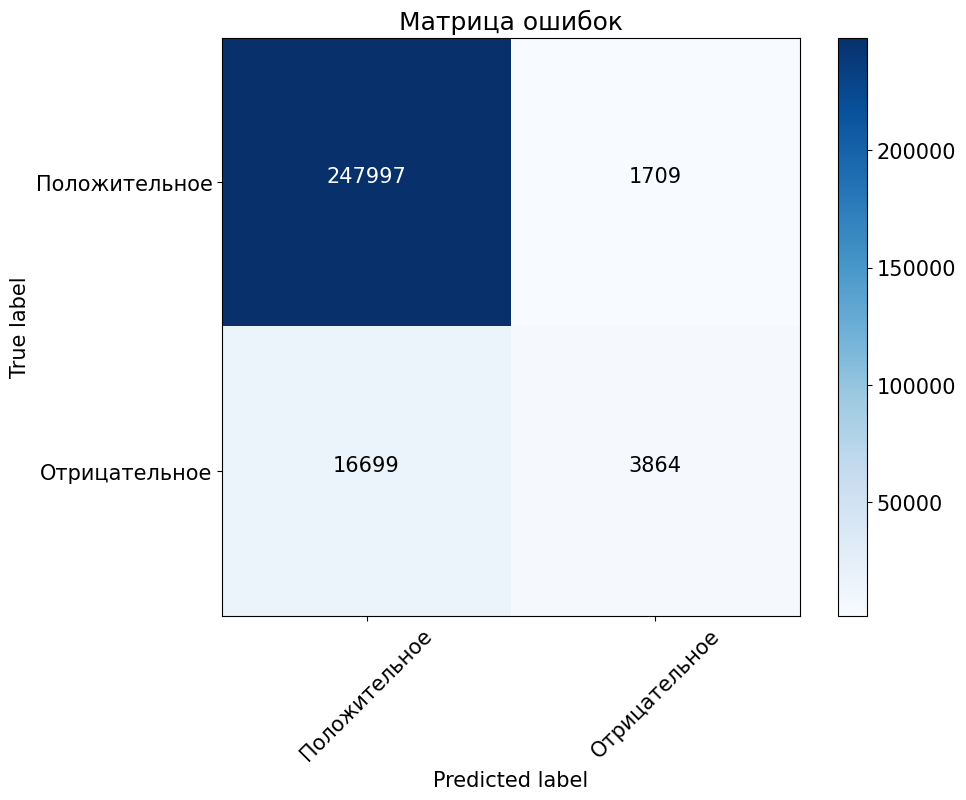

In [21]:
import itertools

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y, model.predict(x))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Положительное', 'Отрицательное'],
                      title='Матрица ошибок')
plt.show()

In [22]:
report = classification_report(y, model.predict(x), target_names=['Положительное', 'Отрицательное'])
print(report)

               precision    recall  f1-score   support

Положительное       0.94      0.99      0.96    249706
Отрицательное       0.69      0.19      0.30     20563

     accuracy                           0.93    270269
    macro avg       0.82      0.59      0.63    270269
 weighted avg       0.92      0.93      0.91    270269



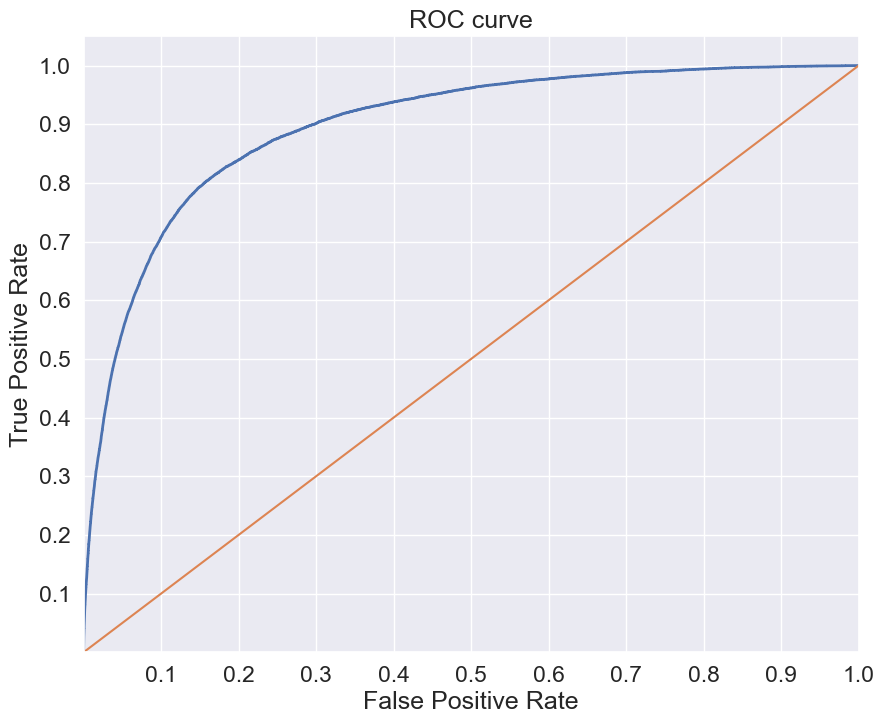

In [23]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y, model.predict_proba(x)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.xticks([i/10 for i in range(1,11)])
plt.ylim([0.0, 1.05])
plt.yticks([i/10 for i in range(1,11)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [24]:
y_prob = model.predict_proba(x)[:, 1]
roc_auc_score(y, y_prob)

0.8971895426967939